# Module 3 Sprint 3 Lending Club  part 1

LendingClub was one of the first American peer-to-peer lending companies, headquartered in San Francisco, California. First peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. Lending Club enables borrowers to create unsecured personal loans between 1,000 USD and 40,000 USD for personal loans and up to 500,000 USD for business use. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

The project is split into 3 parts:

- Part 1 - EDA on accepted/rejected loan applications and machine learning model to predict the loan acceptance or rejection
- Part 2 - EDA on accepted loan dataset and machine learning model to predict the grade of accepted loans
- Part 3 - Machine learning models for accepted loan sub-grade and interest rate predictions

The aim of this part of the project is to build a robust machine learning model that would accurately classify loan applications into accepted and rejected categories and outperform the standard FICO and Debt to Income threshold filter. Information provided by the applicant will be used to build the machine learning model.

As it is equally important to classify positive and negative loan decisions to avoid missed business opportunity and not expose Lending Club investors to loans which are too risky we will use balanced accuracy as the main metric. 

With the above argument in mind we can treat both classes with as equally important for the business. We don't want to reject positive loans applications as the business will lose revenue, at the same time approving loan applications that do not meet credit policy will expose Lending Club customers to high risk loan funding which is a big no no in the eyes of the SEC.

A well performing model would streamline the loan evaluation process, increase the capacity and allow resources to be used more effectively analyzing more complicated cases.

In [1]:
import sys
import os
sys.path.append("src")

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

#statistical tools
import scipy.stats as stats
#Machine Learning
from lazypredict.Supervised import LazyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


from sklearn.metrics import precision_recall_curve,confusion_matrix,balanced_accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

import shap
import optuna
import plots as plot
import utils as utl
import joblib

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
RANDOM_SEED=42
np.set_printoptions(suppress=True)

Run the preprocessing notebook to generate the dataset

In [5]:
run external notebook
%run "./data_preprocessing.ipynb"

Importing the dataset with random downsampling to reduce the dataset to a more managebale size. The random module generates a float between 0 and 1.0 which is then compared to preset probability, so every row starting from 1st has an equal chance of being included in the sample with the pre set probability p

In [6]:
p = 0.1

df = pd.read_csv(
         'all_loans_shuf.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p,
         index_col=[0]
)

In [7]:
df.head()

,amount,employment_length,date,purpose,state,debt_to_income,policy,dti_joint,fico,loan
24329325,35000.00,NaN,2015-02-25 00:00:00,NaN,FL,24.38,0.00,NaN,644.00,0
1148280,10000.00,2.00,Nov-2014,Credit card refinancing,WA,34.55,1.00,NaN,667.00,1
16176191,19000.00,NaN,2016-02-02 00:00:00,NaN,FL,325.00,0.00,NaN,NaN,0
820366,25000.00,10.00,Aug-2018,Debt consolidation,VA,16.87,1.00,NaN,697.00,1
26040405,150000.00,NaN,2015-10-12 00:00:00,NaN,UT,-1.00,0.00,NaN,NaN,0


## Data cleaning

We'll investigate the dataset and have a look at the missing values and do some cleaning for data format and column names

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2991281 entries, 24329325 to 19675757
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   amount             float64
 1   employment_length  float64
 2   date               object 
 3   purpose            object 
 4   state              object 
 5   debt_to_income     float64
 6   policy             float64
 7   dti_joint          float64
 8   fico               float64
 9   loan               int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 251.0+ MB


The dataset has close to 1.5milion observations with 9 features each.

The features available are :

- amount - The listed amount of the loan applied for by the borrower.
- employment_length - Employment length in years declared by the borrower.
- date - Date of the application for loan.
- purpose - Short description defining the reason for the loan.
- state - A two letter US state code, declared residence of the borrower.
- debt_to_income - A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- policy - Lending Club code given to loans and applications ranging from 0 to 2.
- fico - credit score that is used by many lenders to determine if borrowers are eligible for credit card, mortgage or other loans.
- loan - Target value for loan dataset, value of 0 - rejected or 1 - accepted.

Check for missing values

In [9]:
df.isna().sum()

amount                     2
employment_length    2428652
date                       2
purpose              2766726
state                      6
debt_to_income           182
policy                    80
dti_joint            2979190
fico                 1849972
loan                       0
dtype: int64

We can straight away remove entries with missing or zero loan amount values as these are key attributes in LenderClub loan decision making. Also we will set the debt_to_income ratio for joint loan applications.

In [10]:
df=df.dropna(subset=['amount','debt_to_income'])

In [11]:
def override_column(row, current_column, target_column):
    
    if pd.notnull(row[target_column]):
        return row[target_column]
    else:
        return row[current_column]

In [12]:
df['debt_to_income']=df.apply(override_column,axis=1,current_column='debt_to_income',target_column='dti_joint')

After merging debt to income ratios for joint applications we will drop the still missing values of debt to income ratio as there is no reasonable way to impute these important features.

In [13]:
df = df.dropna(subset=['debt_to_income']).loc[df['amount'].ne(0) & df['amount'].notna()]


And we can fix the date column format while we're at it



In [14]:
df['date']=pd.to_datetime(df['date'],format='mixed')
df['date'] = pd.to_datetime(df['date'].fillna(df['date'].apply(lambda x: pd.to_datetime(x, format='%b-%Y', errors='coerce'))))

Cleaning further non sense values

In [15]:
df=df[~(df['debt_to_income'] < 0) & ~(df['debt_to_income'].isna())]

In [16]:
df=df[~(df['debt_to_income']==0) & ~(df['fico']==0)]

Debt to income ratio cannot exceed 100 (which in fact is a terrible score as all monthly debt obligations are equal to monthly income)

In [17]:
df=df[df['debt_to_income']<100]

If the dataset is valid with missing values for fico and employment length, we will try and utilise the power of tree models handling missing values and leave them not filled or imputed at this point.

In [18]:
df.isna().sum()

amount                     0
employment_length    2037070
date                       0
purpose              2322477
state                      0
debt_to_income             0
policy                    78
dti_joint            2534805
fico                 1498419
loan                       0
dtype: int64

## EDA

- employment length in barplot as well?

Lets start with some univariate analysis on target feature balance and general counts to start building dataset understanding before building the model.

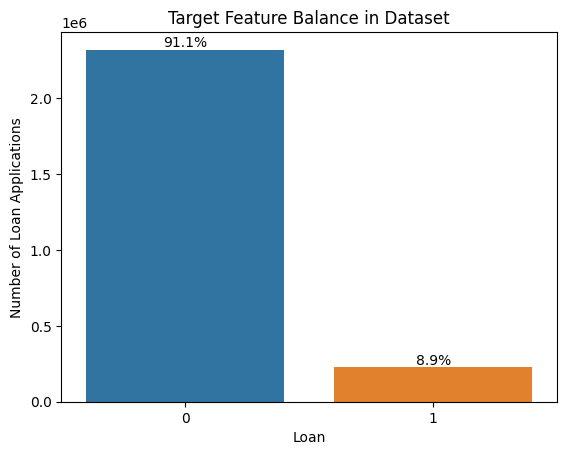

In [19]:
ax=sns.countplot(df,x='loan')
ax.set_title('Target Feature Balance in Dataset')

ax.set_xlabel('Loan')
ax.set_ylabel('Number of Loan Applications')

for c in ax.containers:
    ax.bar_label(c,fmt=lambda v: f"{(v/len(df))*100:0.1f}%")

We can see that the total number of approved loans in the dataset is a clear minority with only 7.6% of loans being approved by Lending club. Lets further investigate factors which lead to the decision

We can also have a look at the ratios from another angle and investigate 'policy2' loans which are deemed to be more risky and only offered to selected institutional investors. These loans do not meet the LendingClub credit criteria of Debt to Income ratio of <40% and FICO score of <660. These types of loans were offered from 2013 and were predicted to account for up to 15% of all offered loans. 

Lets check if any of the policy 2 loans were approved

In [20]:
df[(df['policy']==2) & (df['loan']==1)]

,amount,employment_length,date,purpose,state,debt_to_income,policy,dti_joint,fico,loan


It seems that none of the riskier loans were approved.

LendingClub started operating in 2007, lets have a look at the growth over the years and the ratio of rejected/approved loans.

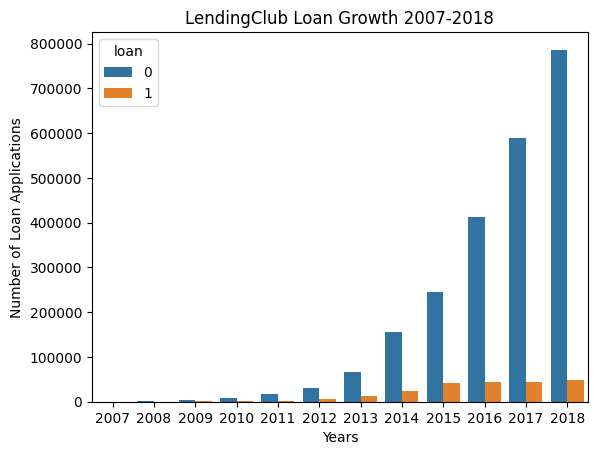

In [21]:
ax=sns.countplot(df,x=df['date'].dt.year,hue='loan')

ax.set_title('LendingClub Loan Growth 2007-2018')
ax.set_ylabel('Number of Loan Applications')
ax.set_xlabel('Years');

We see an exponential growth from 2008 when LendingClub was oficially registered with US. SEC and could star offering financial services to the public. Interesting to note that while the service became popular the approved to rejected loan ratio has steadily decreesed. Signs of responsible financial operations.

Its also worth checking the ratio of approved and rejected loans throughout the years

In [22]:
df['year'] = df['date'].dt.year
ratio_by_year = df.groupby(['year', 'loan']).size().unstack(fill_value=0)
ratio_by_year['ratio'] = ratio_by_year[1] / ratio_by_year[0]

Average approved loan percentage: 13.18%
Latest approved loan percentage: 6.28%


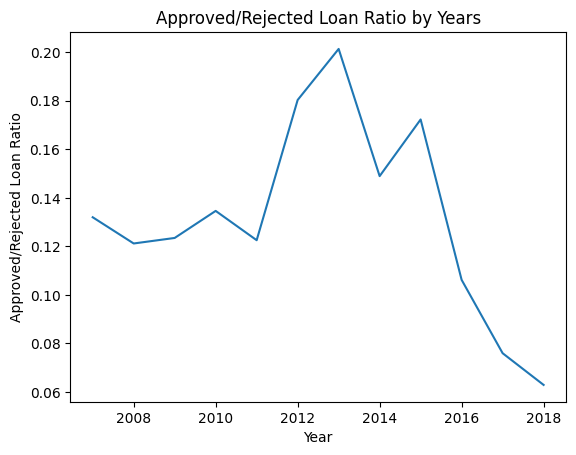

In [23]:
ax=sns.lineplot(ratio_by_year,x='year',y='ratio')

ax.set_title('Approved/Rejected Loan Ratio by Years')
ax.set_xlabel('Year')
ax.set_ylabel('Approved/Rejected Loan Ratio')

print(f"Average approved loan percentage: {ratio_by_year['ratio'].mean()*100:.2f}%")
print(f"Latest approved loan percentage: {ratio_by_year['ratio'].min()*100:.2f}%")

There is a visible growth in approved to rejected loans fromyear 2008 to 2013 followed by  a considerable drop in the ratio from year 2015 to 2018. This can be explained by the exponential growth of loan applications, also most likely more applicant not meeting credit policy criteria.

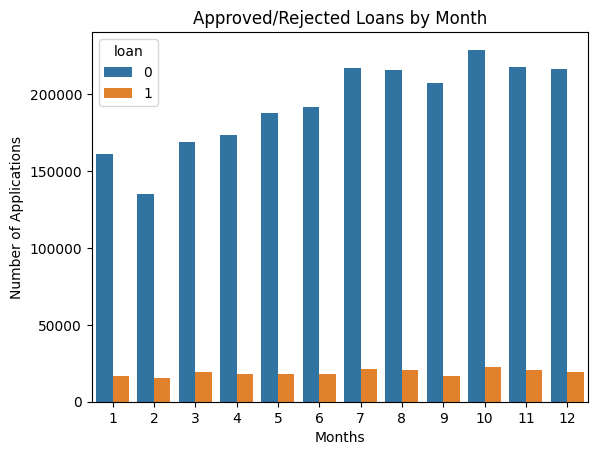

In [24]:
ax=sns.countplot(df,x=df['date'].dt.month,hue='loan')
ax.set_title('Approved/Rejected Loans by Month')
ax.set_xlabel('Months')
ax.set_ylabel('Number of Applications');

There is a small trend of lower loan demand (number of applications) at the start of the year January to May, with February being the lowest demand month. Number of approved loans does not exhibit any different behaviour due to seasonality. 

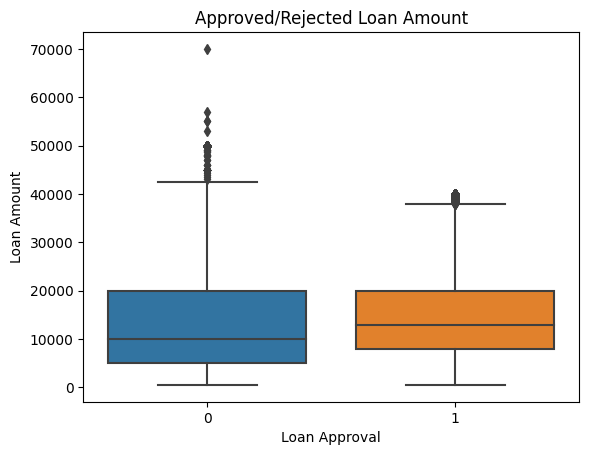

In [25]:
ax=sns.boxplot(df,y='amount',x='loan')
ax.set_title('Approved/Rejected Loan Amount')
ax.set_xlabel('Loan Approval')
ax.set_ylabel('Loan Amount');

In [26]:
print (f"Approved loan mean value: {df[df['loan']==1]['amount'].mean():.2f} USD")
print (f"Rejected loan mean value: {df[df['loan']==0]['amount'].mean():.2f} USD")

Approved loan mean value: 15051.80 USD
Rejected loan mean value: 12509.75 USD


Loan amounts range in the expected 1000 to 40000 USD range as avertised by LendingClub. A few outliers above the specified range can indicate an exception for joint loans or a small business loan. The average amount of loans requested is also slightly higher in the approved category.

Lets have a look at the distribution of FICO scores for accepted and rejected loans. Rejected loan dataset uses two measurements of risk score: FICO until 2013 and Vanguard 4.0 from 2013 , the vanguard 4.0 and FICO have the same grading scale, so lets quickly have a look if the 660 point threshold was still valid for accepted loans from 2013.

In [27]:
df[(df['date']>'2013-01-01')&(df['fico']<660)]['loan'].value_counts()

loan
0    497395
Name: count, dtype: int64

In the data sample no loans accepted with the Vanguard 4.0 score lower than 660, we can treat the sores as comparable

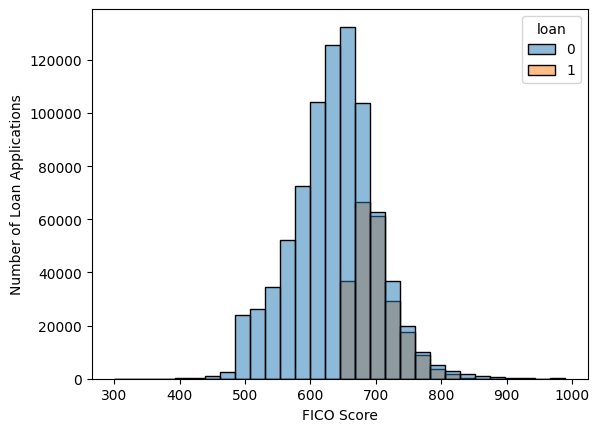

In [28]:
ax=sns.histplot(df,x='fico',bins=30,hue='loan')
ax.set_label('Distribution of FICO Score for Approved/Rejected Loans')
ax.set_ylabel('Number of Loan Applications')
ax.set_xlabel('FICO Score');

In [29]:
print (f"Approved loan mean FICO score: {df[df['loan']==1]['fico'].mean():.2f}")
print (f"Rejected loan mean FICO score: {df[df['loan']==0]['fico'].mean():.2f}")

Approved loan mean FICO score: 700.52
Rejected loan mean FICO score: 635.41


We can see a normal distribution in FICO scores from the sample, the underlying accepted loan FICO score distribution has a right skew indicating that the 660 FICO score holds as a solid threshold for loan approval. 

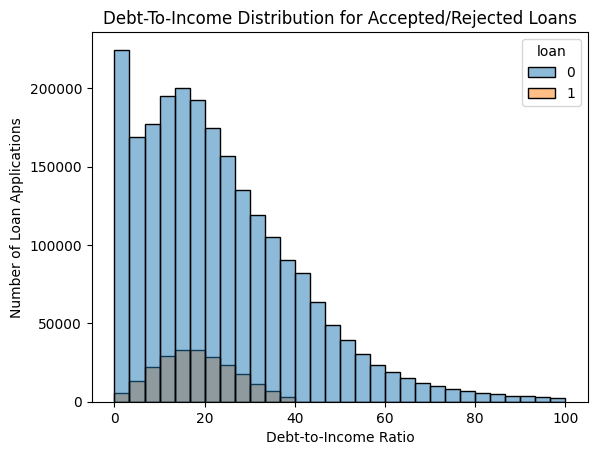

In [30]:
ax=sns.histplot(x=df['debt_to_income'],bins=30,hue=df['loan'])

ax.set_title('Debt-To-Income Distribution for Accepted/Rejected Loans')
ax.set_ylabel('Number of Loan Applications')
ax.set_xlabel('Debt-to-Income Ratio');


In [31]:
print (f"Approved loan mean debt-to-income ratio: {df[df['loan']==1]['debt_to_income'].mean():.2f}")
print (f"Rejected loan mean debt-to-income ratio: {df[df['loan']==0]['debt_to_income'].mean():.2f}")

Approved loan mean debt-to-income ratio: 18.16
Rejected loan mean debt-to-income ratio: 23.46


The distributions of debt to income values has a spike on the lower end of the value range and a skew to the right. The underlying accepted loan distribution of deb to income shows a more normal distribution providing an indication that the more extreme values of debt to income ratio are comming from rejected loan applications and can be attributed to error or intentional false information entry during the application process.

Since Lending Club declares that FICO(risk score) and debt to income ratio are two main factors in loan approval. Lets investigate if there is a clear distinction in the feature space and potentially an indication of a new feature.

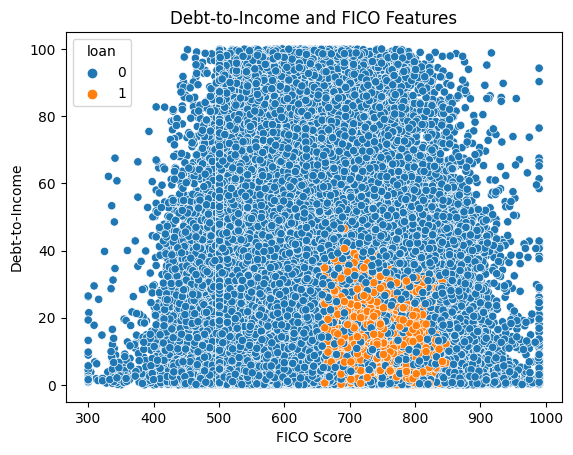

In [32]:
ax=sns.scatterplot(df,x='fico',y='debt_to_income',hue='loan')
ax.set_title('Debt-to-Income and FICO Features')
ax.set_ylabel('Debt-to-Income')
ax.set_xlabel('FICO Score');

We can see a clear cluster of approved loans with higher FICO score and lower Debt-to-Income ratio. However, rejected loans are also populating the cluster indicating that the two features are not the only factors in decision making at Lending Club.

#### EDA summary

- Approved loan mean value: 15090.91 USD, Rejected loan mean value: 12505.51 USD
- Loan approval to rejection ratio is close to 1:9, indicating both the big demand for loans and rather strict approval criteria.
- Lending Club loan applications grew exponentially throughout the date range of the dataset, however the approval rate did not follow the same trajectory
- Ratio of approved to rejected loans experienced growth from years 2008 to 2013 and then a sharp decline to 2018 where it reached a value of 6%


## Hypothesis Testing

In order to get a better understanding for the particlar dataset we'll answer the question if duration of employment has an impact on requested loan amount. We will look at the approved loans only.

Ho - There is no significant difference in the average loan amount among accepted loan applicants

Alternative hypothesis- There is a significant difference in the mean loan amount based on employment length.

In [33]:
emp_length_1=df[(df['employment_length']<=3) & (df['loan']==1)]['amount']
emp_length_2=df[(df['employment_length']>3) & (df['loan']==1)]['amount']

In [34]:
print(len(emp_length_1))
print(len(emp_length_2))

53459
139465


With sufficiently large sample sizes we will put our trust in the central limit theorem that suggest sample mean distribution to be aproximately normal even if the underlying population distribution is not normal. A two-tailed t-test will be used to test the outlined hypothesis and compared to alpha value of 0.05 as significance threshold.

In [35]:
t_statistic,p_value=stats.ttest_ind(emp_length_1,emp_length_2)

In [36]:
print (f"t-Test p-value:{p_value}")

t-Test p-value:5.040371778941139e-199


With the observed p-value lower than the set threshold we can infer that there is a statistically significant difference in mean loan amount requested for different employment durations of applicants.

## Machine Learning model

As already mentioned the chosen metric for the binary classifier is balanced accuracy as we are dealing with inbalanced dataset and need to correctly idenfity both classes, this metric will give equal weight to both classes.

As most of the features are numerical we won't need too much encoding. We will drop date feature as we haven't observed any clear trends or indications that certain months might have an impact on approval process. Also purpose and state will be dropped due to high cardinality. Policy is a feature that is assigned after the loan evaluation, so to prevent data leakage it is also dropped.

In [37]:
cols_to_drop=['date','purpose','state','policy','dti_joint','year']

In [38]:
df_ml=df.drop(columns=cols_to_drop)

Drop any duplicates that might have originated after dropping the columns, this will prevent any data leakage when splitting the dataset.

In [39]:
df_ml=df_ml.drop_duplicates()

In [40]:
X=df_ml[['amount',
 'employment_length',
 'debt_to_income',
 'fico',
 ]]
y=df_ml['loan']

Lets do a bit of lazy classification and check which model might be best suited for loan decision prediction, we will take  a sample of the dataframe to speed up the process. And also use the balanced accuracy as a baseline prediction score.

In [41]:
X_train, X_test, y_train, y_test=utl.sample_and_split(df_ml,'loan',20000,42)

In [42]:
clf = LazyClassifier(verbose=False,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

models[:5]

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]

[LightGBM] [Info] Number of positive: 2128, number of negative: 11872
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.152000 -> initscore=-1.719000
[LightGBM] [Info] Start training from score -1.719000


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.97,0.96,0.96,0.97,0.23
XGBClassifier,0.96,0.94,0.94,0.96,0.10
RandomForestClassifier,0.95,0.92,0.92,0.95,1.27
AdaBoostClassifier,0.95,0.91,0.91,0.95,0.40
BaggingClassifier,0.94,0.90,0.90,0.94,0.22


We can see that the best performing models are all tree based, so we will pick the top performer for further hyperparameter tuning and final scoring.

We will take also take LGBMClassifier Balanced Accuracy score as our baseline metric - 0.94 on the sub-sample set.

### LightGBM model

The best result obtained from the auto ML tool suggest that LGBM classifier achieved the best balanced accuracy. We will tak the model and tune the hyperparameters to squeeze the last bit of performance out of it.
Hyperparameters will be tuned using Optuna to save a lot of time and skip the cumbersome grid search method

Split the sample dataset into train/validation and test partitions 60%/20%/20% respective.

In [43]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=RANDOM_SEED)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED)

In [44]:
pipe=Pipeline([
    ("classifier",LGBMClassifier(is_unbalanced=True,verbose=-100))
])

Define Optuna objective 

In [45]:
def objective(trial):
    
    param = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'logloss',
        'is_unbalanced': True,
        'scale_post_weight': 9,
        'verbose': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),#changed 0.1 to 0.3
        'num_leaves': trial.suggest_int('num_leaves', 31, 128),
        'subsample_for_bin':trial.suggest_int('subsample_for_bin',10000,40000),
        'n_estimators': trial.suggest_int('n_estimators', 2, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0.8, 1.0),
        'subsample': trial.suggest_float('subsample',0.8,1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 19),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'min_chil_weight' : trial.suggest_float('min_child_weight',0.001,0.005),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),    
    }
    


    model = LGBMClassifier(**param)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    balanced_accuracy=balanced_accuracy_score(y_val,predictions)
    return balanced_accuracy

In [ ]:
study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=100)

The model is trained, lets investigate the performance

In [47]:
print(f"Tuned model best balanced accuracy score:{study.best_value:.3f}")

Tuned model best balanced accuracy score:0.964


We wil build the tuned model pipeline with the best hyperparameters.

In [57]:
pipe=Pipeline(
    [
        ("classifier", LGBMClassifier(**study.best_params,verbose=-1)),
    ]
)

In [58]:
approval_model=pipe.fit(X_train,y_train)

In [59]:
y_pred=approval_model.predict(X_val)

And the normalized confussion matrix for the model on the validation set

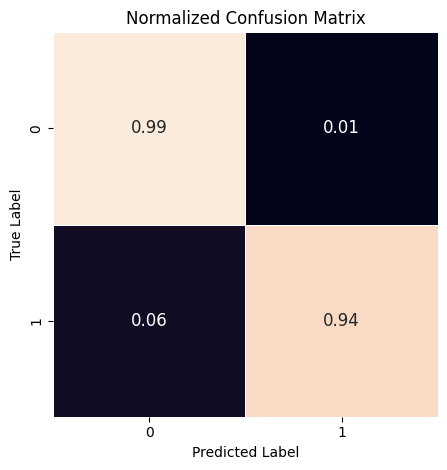

In [60]:
plot.norm_confusion_plot(y_val,y_pred,y.unique())

#### Model explainability

Lets evaluate the how the model is making decisions using SHAP explainer

In [61]:
shap.initjs()

In [62]:
explainer=shap.TreeExplainer(approval_model["classifier"])

In [64]:
observations = (
    X_train.sample(1000, random_state=RANDOM_SEED)
)
shap_values = explainer.shap_values(observations)

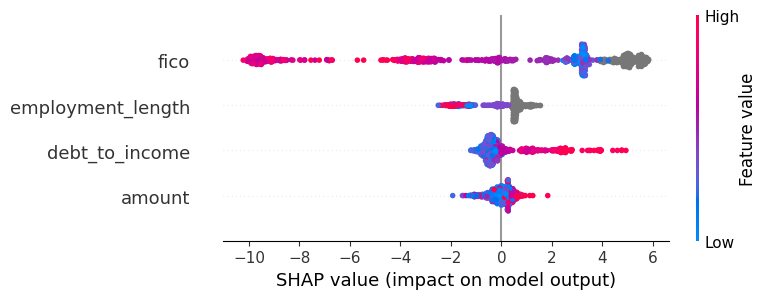

In [65]:
shap.summary_plot(shap_values[0], features=observations, feature_names=X_train.columns)

Looking at the Shapley values 'fico' feature is clearly most impactful on the decision made by the classifier. Debt to income ratio is also a significant factor. As expected these features are the most important and thus are used by Lending Club as the core criteria for loan approval/rejection

And finally lets check how the model performs on the holdout test set

#### Model test on holdout set

In [66]:
y_pred=approval_model.predict(X_test)

In [67]:
print(f"Model balanced accuracy score on test set:{balanced_accuracy_score(y_test,y_pred):.2f}")

Model balanced accuracy score on test set:0.96


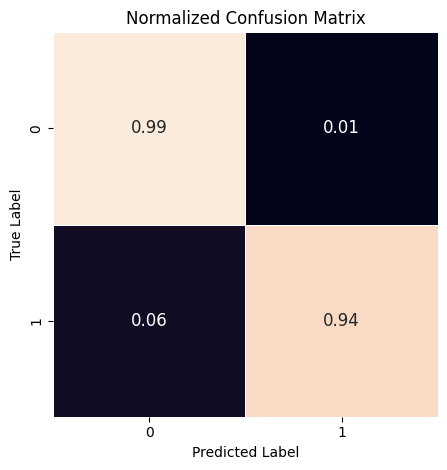

In [68]:
plot.norm_confusion_plot(y_test,y_pred,y.unique())

Tuned model achieved balanced accuracy score of 0.96 on the holdout dataset

Export the model

In [71]:
filename = 'acc_rej_clf.sav'
joblib.dump(approval_model, filename)

['acc_rej_clf.sav']

## Conclusions


LightGBM model was trained and tested on sampled dataset for accepted/rejected Lending Club loans. Chosen metric for model evaluation was Balanced Accuracy due to inbalance of the target feature, score achieved on the holdout test set:
- 0.96

Hypothesis that employment length is associated with loan amount requested was checked using two tailed t-Test. Test results allows us to infer that employment length is a significant factor in loan ammount requested.


Model was exported and will be deployed with other classificators.

Please see part 2 of the project located at 'Part2_loan_grade.ipynb'

## Possible improvements

However, Lending Club started offering higher risk profile loans which can be funded only by select institutional investors. These loans do not meet Lending Club credit policy and have restrictions on duration and total amount, but are still offered as a product. A third class could be introduced to classify these loans and increase business scope of Lending Club further.

## Resources

(Source: Qualifying for a personal loan. Lendingclub Q&A. https://help.lendingclub.com/hc/en-us/articles/213706208-Qualifying-for-a-personal-loan.